# Unstructured
- https://unstructured.io/
- https://unstructured-io.github.io/unstructured/index.html
- https://docs.unstructured.io/api-reference/api-services/python-sdk


## Setup

In [1]:
%%capture
%pip install "unstructured[all-docs]" unstructured-client watermark

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import JSON

import json

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements, elements_to_json

In [3]:
%load_ext watermark

In [4]:
import unstructured

In [ ]:
%watermark --iversions

## Initial exploration ( extract elements)

In [ ]:
import unstructured.partition

help(unstructured.partition)

In [7]:
from unstructured.partition.pdf import partition_pdf

# Specify the path to your PDF file
filename = "data/gpt4all.pdf"
filename = "data/t1.pdf"

# Call the partition_pdf function
# Returns a List[Element] present in the pages of the parsed pdf document
elements = partition_pdf(filename)

# Now, elements is a list of all elements present in the pages of the parsed pdf document

In [ ]:
elements

In [ ]:
len(elements)

In [ ]:
element_dict = [el.to_dict() for el in elements]
output = json.dumps(element_dict, indent=2)
print(output)

In [ ]:
unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

##### We don't see `Image`, image information is not extracted as we expected, lets use different strategy.

### Image extraction from PDF
- Now let’s say that your PDF has tables and let’s say you want to preserve the image data. 
- You will have to specify the [strategy](https://unstructured-io.github.io/unstructured/best_practices/strategies.html) parameter as `hi_res`. This will use a combination of computer vision and Optical Character Recognition (OCR) to extract the tables and maintain the structure. 

> Note: For even better image extraction Unstructured offers an API that improves upon the existing open source models.

> Depending upon machine, you might face different module / library issues, these links might help
- https://stackoverflow.com/questions/59690698/modulenotfounderror-no-module-named-lzma-when-building-python-using-pyenv-on
- https://unstructured-io.github.io/unstructured/installation/full_installation.html

In [12]:
from unstructured.partition.pdf import partition_pdf

elements = partition_pdf(filename=filename,
                     strategy='hi_res',
           )

In [ ]:
element_dict = [el.to_dict() for el in elements]

unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

In [ ]:
images = [el for el in elements if el.category == "Image"]

print(images[4].text)
print(images[4].metadata.text_as_html)

In [ ]:
images

In [ ]:
len(images)

## Another way ( extract / display images + elements )

In [ ]:
partition_pdf??

In [ ]:
# Get elements
path = "images"
raw_pdf_elements = partition_pdf(filename=filename,
                                 # Unstructured first finds embedded image blocks
                                 # Only applicable if `strategy=hi_res`
                                 extract_images_in_pdf=True,
                                 strategy = "hi_res",
                                 infer_table_structure=True,
                                 # Only applicable if `strategy=hi_res`
                                 extract_image_block_output_dir = path,
                                 )

In [ ]:
element_dict = [el.to_dict() for el in raw_pdf_elements]

unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

In [ ]:
images = [el for el in raw_pdf_elements if el.category == "Image"]

print(images[4].text)
print(images[4].metadata.text_as_html)

### Let's display the images extracted

In [ ]:
from IPython.display import Image, display
import glob

# Define the path to the folder containing the images
folder_path = "images/*.jpg"  # Update the file type as needed

# Use glob to search for JPG files in the specified folder
image_files = glob.glob(folder_path)

# Iterate through the list of image files and display each image inline
for image_file in image_files:
    display(Image(filename=image_file))

## Multi-modal (explain image using Llava)
#### Now, lets plugin in LangChain to explaiin the image using `Llava` via `Ollama`. More info in this [link](https://python.langchain.com/v0.1/docs/integrations/llms/ollama/)
#### [Ollama Playlist](https://www.youtube.com/playlist?list=PLz-qytj7eIWX-bpcRtvkixvo9fuejVr8y)

In [24]:
%%capture
%pip install langchain langchain_core langchain_community

In [25]:
from langchain_community.llms import Ollama

In [ ]:
Ollama??

In [27]:
llm = Ollama(model="llama3.1:8b")#llava:7b")

In [ ]:
import PIL
print(PIL.__version__)


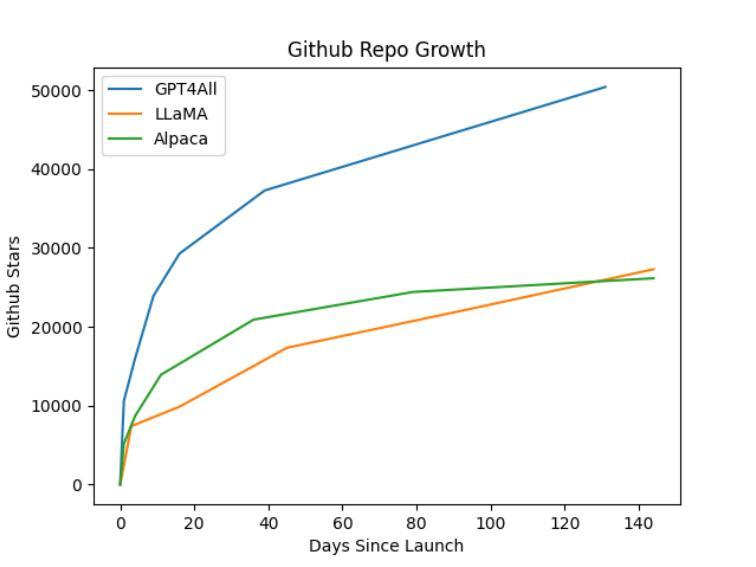

In [35]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "./images/figure-4-5.jpg"
pil_image = Image.open(file_path)
image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [ ]:
llm_with_image_context = llm.bind(images=[image_b64])
llm_with_image_context.invoke("Explain the image")